C:\Users\maahi\AppData\Local\Temp\ipykernel_22476\4143632242.py:14: DtypeWarning: Columns (10,11,13,18,19,34,50) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('ashrae_db2.01.csv')


Logistic Regression Accuracy: 0.4134
Random Forest Accuracy: 0.4644
Support Vector (SVC) Accuracy: 0.4232


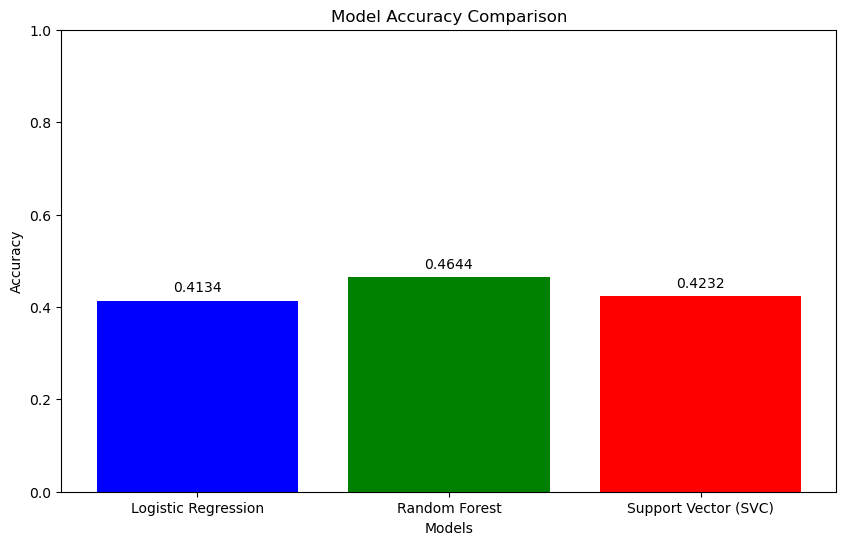


Best model: Random Forest with accuracy 0.4644


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import pickle
from collections import Counter

# Load and preprocess data
data = pd.read_csv('ashrae_db2.01.csv')
data_clean = data[['Air temperature (C)', 'Relative humidity (%)', 'Thermal comfort']].dropna()
data_clean['Thermal comfort'] = pd.to_numeric(data_clean['Thermal comfort'], errors='coerce').dropna()

# Categorize comfort levels
def categorize_comfort(value):
    if value <= 2: return 0  # Uncomfortable
    elif value <= 4: return 1  # Moderate
    else: return 2  # Comfortable

data_clean['comfort_category'] = data_clean['Thermal comfort'].apply(categorize_comfort)

# Balance classes
min_samples = data_clean['comfort_category'].value_counts().min()
balanced_data = pd.concat([
    data_clean[data_clean['comfort_category'] == 0].sample(min_samples, random_state=42),
    data_clean[data_clean['comfort_category'] == 1].sample(min_samples, random_state=42),
    data_clean[data_clean['comfort_category'] == 2].sample(min_samples, random_state=42)
])

# Feature engineering
balanced_data['temp_humidity_ratio'] = balanced_data['Air temperature (C)'] / (balanced_data['Relative humidity (%)'] + 0.001)
balanced_data['heat_index'] = 0.5 * (balanced_data['Air temperature (C)'] + 61.0 + 
                                   ((balanced_data['Air temperature (C)'] - 68.0) * 1.2) + 
                                   (balanced_data['Relative humidity (%)'] * 0.094))

# Prepare data
X = balanced_data[['Air temperature (C)', 'Relative humidity (%)', 'temp_humidity_ratio', 'heat_index']]
y = balanced_data['comfort_category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Support Vector (SVC)": SVC(random_state=42)
}

# Train models and store accuracies
accuracies = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    accuracies[name] = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {accuracies[name]:.4f}")

# Plot accuracies
plt.figure(figsize=(10, 6))
plt.bar(accuracies.keys(), accuracies.values(), color=['blue', 'green', 'red'])
plt.title('Model Accuracy Comparison')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.ylim(0, 1.0)
for i, v in enumerate(accuracies.values()):
    plt.text(i, v + 0.02, f"{v:.4f}", ha='center')
plt.savefig('model_accuracy_comparison.png')
plt.show()

# Save best model
best_model_name = max(accuracies, key=accuracies.get)
best_model = models[best_model_name]
with open('best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

print(f"\nBest model: {best_model_name} with accuracy {accuracies[best_model_name]:.4f}")

In [ ]:
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import StandardScaler

def predict_comfort(temp, humidity):
    """Predict comfort category from user input"""
    # Create features (same as training)
    temp_humidity_ratio = temp / (humidity + 0.001)
    heat_index = 0.5 * (temp + 61.0 + ((temp - 68.0) * 1.2) + (humidity * 0.094))
    
    # Create input array
    X_new = np.array([[temp, humidity, temp_humidity_ratio, heat_index]])
    
    # Scale features (important!)
    X_new_scaled = scaler.transform(X_new)
    
    # Make prediction
    pred = model.predict(X_new_scaled)[0]
    
    # Map to comfort categories
    comfort_map = {
        0: "Uncomfortable",
        1: "Moderately Comfortable", 
        2: "Comfortable"
    }
    return comfort_map[pred]

# User input loop
print("Thermal Comfort Predictor")
print("Enter temperature (°C) and relative humidity (%) to check comfort level")
print("Type 'quit' to exit\n")

while True:
    user_input = input("Enter temperature,humidity (e.g., 24.5,60): ")
    
    if user_input.lower() == 'quit':
        break
        
    try:
        temp, humidity = map(float, user_input.split(','))
        
        if not (-50 <= temp <= 50):
            print("Temperature must be between -50°C and 50°C")
            continue
        if not (0 <= humidity <= 100):
            print("Humidity must be between 0% and 100%")
            continue
            
        comfort = predict_comfort(temp, humidity)
        print(f"\nAt {temp}°C and {humidity}% humidity:")
        print(f"Predicted comfort level: {comfort}\n")
        
    except ValueError:
        print("Invalid input. Please enter values as temperature,humidity (e.g., 24.5,60)")

print("\nThank you for using the Thermal Comfort Predictor!")

Thermal Comfort Predictor
Enter temperature (°C) and relative humidity (%) to check comfort level
Type 'quit' to exit



In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import joblib

# Load dataset
data = pd.read_csv('ashrae_db2.01.csv')

# Preprocessing
data_clean = data[['Air temperature (C)', 'Relative humidity (%)', 
                  'Thermal comfort', 'Cooling startegy_building level']].copy()
data_clean = data_clean.dropna()
data_clean['Thermal comfort'] = pd.to_numeric(data_clean['Thermal comfort'], errors='coerce')
data_clean = data_clean.dropna(subset=['Thermal comfort'])

# Categorize comfort levels
def categorize_comfort(value):
    if value <= 2: return 0  # Uncomfortable
    elif value <= 4: return 1  # Moderate
    else: return 2  # Comfortable

data_clean['comfort_category'] = data_clean['Thermal comfort'].apply(categorize_comfort)

# Balance classes
min_samples = data_clean['comfort_category'].value_counts().min()
balanced_data = pd.concat([
    data_clean[data_clean['comfort_category'] == 0].sample(min_samples, random_state=42),
    data_clean[data_clean['comfort_category'] == 1].sample(min_samples, random_state=42),
    data_clean[data_clean['comfort_category'] == 2].sample(min_samples, random_state=42)
])

# Feature engineering
balanced_data['temp_humidity_ratio'] = balanced_data['Air temperature (C)'] / (balanced_data['Relative humidity (%)'] + 0.001)
balanced_data['heat_index'] = 0.5 * (balanced_data['Air temperature (C)'] + 61.0 + 
                            ((balanced_data['Air temperature (C)'] - 68.0) * 1.2) + 
                            (balanced_data['Relative humidity (%)'] * 0.094))

# Prepare data
X = balanced_data[['Air temperature (C)', 'Relative humidity (%)', 
                  'temp_humidity_ratio', 'heat_index', 
                  'Cooling startegy_building level']]
y = balanced_data['comfort_category']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing pipeline
numeric_features = ['Air temperature (C)', 'Relative humidity (%)', 
                   'temp_humidity_ratio', 'heat_index']
categorical_features = ['Cooling startegy_building level']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Random Forest model
rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Train model
rf_model.fit(X_train, y_train)

# Evaluate model
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Evaluation:")
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Save model
joblib.dump(rf_model, 'thermal_comfort_model_with_cooling.pkl')

# Prediction function
def predict_comfort_with_cooling(temp, humidity, cooling_strategy):
    """Predict comfort including cooling strategy"""
    # Create features
    temp_humidity_ratio = temp / (humidity + 0.001)
    heat_index = 0.5 * (temp + 61.0 + ((temp - 68.0) * 1.2) + (humidity * 0.094))
    
    # Create input DataFrame
    input_data = pd.DataFrame([[temp, humidity, temp_humidity_ratio, heat_index, cooling_strategy]],
                            columns=['Air temperature (C)', 'Relative humidity (%)',
                                    'temp_humidity_ratio', 'heat_index',
                                    'Cooling strategy_building level'])
    
    # Predict
    pred = rf_model.predict(input_data)[0]
    
    comfort_map = {
        0: "Uncomfortable",
        1: "Moderately Comfortable", 
        2: "Comfortable"
    }
    return comfort_map[pred]

# Interactive prediction
print("\nThermal Comfort Predictor (with Cooling Strategy)")
print("Available cooling strategies: Air Conditioned, Mechanically Ventilated, Mixed Mode, Naturally Ventilated")
print("Enter values as: temperature,humidity,cooling_strategy")
print("Example: 24.5,60,Air Conditioned\n")

while True:
    user_input = input("Enter values or 'quit': ")
    
    if user_input.lower() == 'quit':
        break
        
    try:
        temp, humidity, cooling = user_input.split(',')
        temp = float(temp.strip())
        humidity = float(humidity.strip())
        cooling = cooling.strip()
        
        if cooling not in ['Air Conditioned', 'Mechanically Ventilated', 'Mixed Mode', 'Naturally Ventilated']:
            print("Invalid cooling strategy. Please use one of:")
            print("Air Conditioned, Mechanically Ventilated, Mixed Mode, Naturally Ventilated")
            continue
            
        comfort = predict_comfort_with_cooling(temp, humidity, cooling)
        print(f"\nAt {temp}°C, {humidity}% humidity, {cooling}:")
        print(f"Predicted comfort: {comfort}\n")
        
    except ValueError:
        print("Invalid input format. Please use: temperature,humidity,cooling_strategy")

print("\nPrediction complete!")


C:\Users\maahi\AppData\Local\Temp\ipykernel_35212\2807815798.py:12: DtypeWarning: Columns (10,11,13,18,19,34,50) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('ashrae_db2.01.csv')



Model Evaluation:
Accuracy: 0.4830

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.60      0.58       701
           1       0.42      0.41      0.42       696
           2       0.45      0.43      0.44       686

    accuracy                           0.48      2083
   macro avg       0.48      0.48      0.48      2083
weighted avg       0.48      0.48      0.48      2083


Thermal Comfort Predictor (with Cooling Strategy)
Available cooling strategies: Air Conditioned, Mechanically Ventilated, Mixed Mode, Naturally Ventilated
Enter values as: temperature,humidity,cooling_strategy
Example: 24.5,60,Air Conditioned

